In [30]:
#follow Visium Fluoresence tutorial for PA12 analysis, follow Visium H&E tutorial for PA04 analysis

#fluoresence first
# (also i should find out what is cytassist lowkey)

import pandas as pd
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import squidpy as sq
import numpy as np

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")
#importing the spatial data using read_visium 
adata_PA12 = sc.read_visium("spatial_data", load_images=True)
#SPATIAL_DATA CONTAINS PATIENT 12 DATA

# #get the tissue image and the spatial coordinates csv

# coords = pd.read_csv("spatial_data/spatial/tissue_positions_list.csv", header=None, index_col=0)
# coords = coords.loc[adata_PA12.obs_names] #order the coords in the same way as adata object
# # coords.head()
# adata_PA12.obsm["spatial"] = coords

# adata_PA12.obs

scanpy==1.10.3 anndata==0.10.8 umap==0.5.9.post2 numpy==1.26.4 scipy==1.13.1 pandas==2.3.2 scikit-learn==1.6.1 statsmodels==0.14.5 igraph==0.11.9 pynndescent==0.5.13
squidpy==1.6.1


/Users/anushkadole/PDAC-scRNA/.venv/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/anushkadole/PDAC-scRNA/.venv/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [31]:
#standard scanpy clustering and umap workflow
sc.pp.normalize_total(adata_PA12)
sc.pp.log1p(adata_PA12)
sc.pp.pca(adata_PA12)
sc.pp.neighbors(adata_PA12)
sc.tl.umap(adata_PA12)
sc.tl.leiden(adata_PA12)
adata_PA12

AnnData object with n_obs × n_vars = 4855 × 18085
    obs: 'in_tissue', 'array_row', 'array_col', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'log1p', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

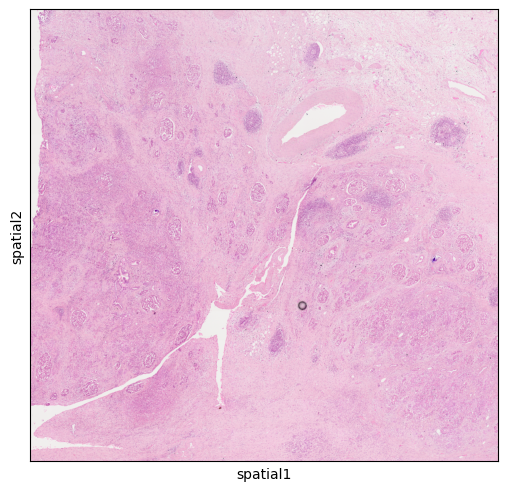

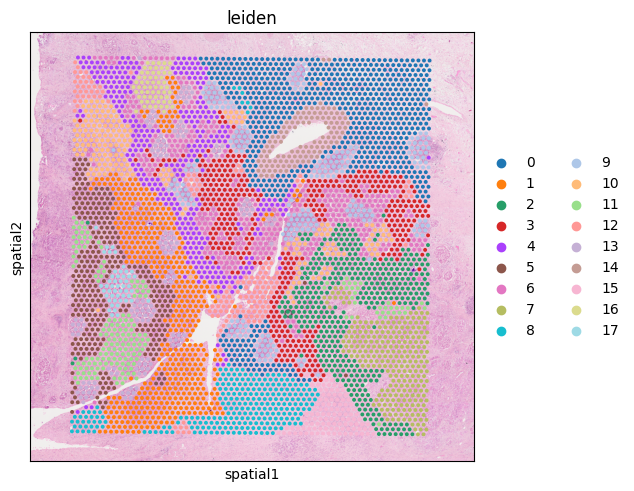

In [34]:
#seeing if it actually worked
sq.pl.spatial_scatter(adata_PA12, size=1)
sq.pl.spatial_scatter(adata_PA12, color="leiden", size=1)

In [45]:
import json
img_path = "spatial_data/spatial/tissue_hires_image.png"
img = sq.im.ImageContainer(img_path)
with open("spatial_data/spatial/scalefactors_json.json") as f:
    sf = json.load(f)
scl = sf["tissue_hires_scalef"]
adata_PA12.obsm["spatial"] = adata_PA12.obsm["spatial"].copy() * scl
#scaling the coordinates to match the highres image

# calculate features for different scales (higher value means more context)
for scale in [1.0, 2.0]:
    feature_name = f"features_summary_scale{scale}"
    sq.im.calculate_image_features(
        adata_PA12,
        img.compute(),
        features="summary",
        key_added=feature_name,
        n_jobs=4,
        scale=scale,
    )


# combine features in one dataframe
adata_PA12.obsm["features"] = pd.concat(
    [adata_PA12.obsm[f] for f in adata_PA12.obsm.keys() if "features_summary" in f],
    axis="columns",
)
# make sure that we have no duplicated feature names in the combined table
adata_PA12.obsm["features"].columns = ad.utils.make_index_unique(
    adata_PA12.obsm["features"].columns
)

  0%|          | 0/4855 [00:00<?, ?/s]

/Users/anushkadole/PDAC-scRNA/.venv/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/Users/anushkadole/PDAC-scRNA/.venv/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/Users/anushkadole/PDAC-scRNA/.venv/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/Users/anushkadole/PDAC-scRNA/.venv/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/Users/anushkadole/PDAC-scRNA/.venv/lib/python3.9/site-packages/numba/core/decorators.py:246: Runtim

  0%|          | 0/4855 [00:00<?, ?/s]

/Users/anushkadole/PDAC-scRNA/.venv/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [46]:
adata_PA12.obsm["features"].head()


,summary_ch-0_quantile-0.9,summary_ch-0_quantile-0.5,summary_ch-0_quantile-0.1,summary_ch-0_mean,summary_ch-0_std,summary_ch-1_quantile-0.9,summary_ch-1_quantile-0.5,summary_ch-1_quantile-0.1,summary_ch-1_mean,summary_ch-1_std,...,summary_ch-1_quantile-0.9-1,summary_ch-1_quantile-0.5-1,summary_ch-1_quantile-0.1-1,summary_ch-1_mean-1,summary_ch-1_std-1,summary_ch-2_quantile-0.9-1,summary_ch-2_quantile-0.5-1,summary_ch-2_quantile-0.1-1,summary_ch-2_mean-1,summary_ch-2_std-1
AACACCTACTATCGAA-1,239.0,0.0,0.0,64.884304,103.882039,228.0,0.0,0.0,56.979681,92.918900,...,220.0,0.0,0.0,56.859334,92.231192,230.0,0.0,0.0,62.266588,99.515391
AACACGTGCATCGCAC-1,238.0,0.0,0.0,58.926924,100.804004,223.0,0.0,0.0,51.927520,90.413821,...,215.0,0.0,0.0,51.817500,89.747162,228.0,0.0,0.0,56.624163,96.683748
AACACTTGGCAAGGAA-1,239.0,0.0,0.0,61.638691,102.259142,225.0,0.0,0.0,54.242990,91.616214,...,217.0,0.0,0.0,54.128021,90.938733,229.0,0.0,0.0,59.199326,98.032750
AACAGGAAGAGCATAG-1,238.0,0.0,0.0,58.924852,100.798556,223.0,0.0,0.0,51.919470,90.410835,...,215.0,0.0,0.0,51.811128,89.745854,228.0,0.0,0.0,56.624096,96.682227
AACAGGATTCATAGTT-1,239.0,0.0,0.0,60.728731,101.779445,225.0,0.0,0.0,53.463857,91.225247,...,217.0,0.0,0.0,53.350613,90.551537,229.0,0.0,0.0,58.337651,97.592305


/Users/anushkadole/PDAC-scRNA/.venv/lib/python3.9/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


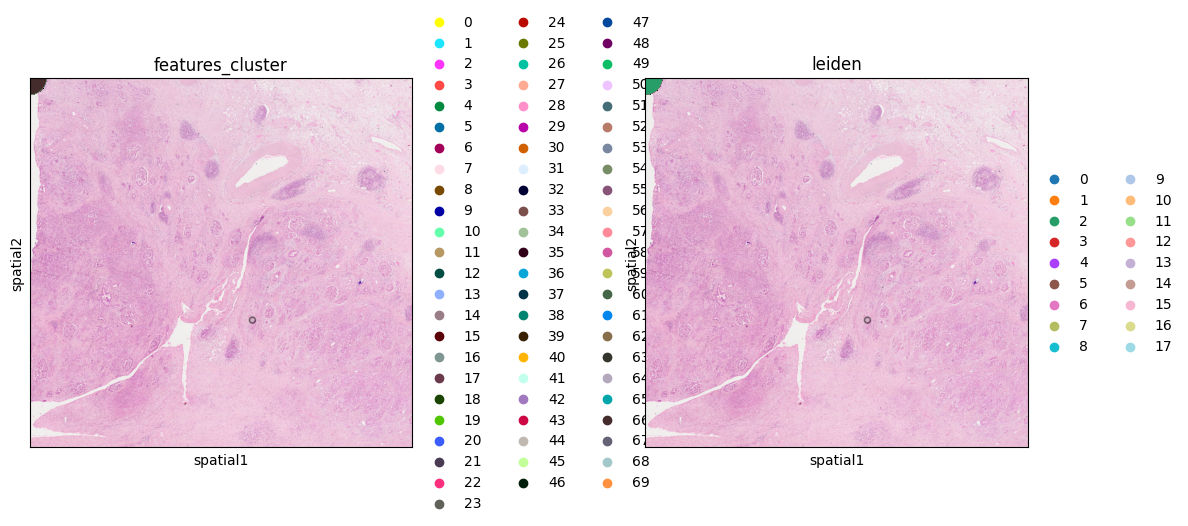

In [62]:
# helper function returning a clustering
def cluster_features(features: pd.DataFrame, like=None) -> pd.Series:
    #like is a string to filter the features
    """
    Calculate leiden clustering of features.

    Specify filter of features using `like`.
    """
    # filter features
    if like is not None:
        features = features.filter(like=like)
    # create temporary adata to calculate the clustering
    adata = ad.AnnData(features)
    # important - feature values are not scaled, so need to scale them before PCA
    sc.pp.scale(adata)
    # calculate leiden clustering
    sc.pp.pca(adata, n_comps=min(15, features.shape[1] - 1))
    sc.pp.neighbors(adata, n_pcs=15)
    sc.tl.leiden(adata, resolution=0.4)

    return adata.obs["leiden"]


# calculate feature clusters
adata_PA12.obs["features_cluster"] = cluster_features(adata_PA12.obsm["features"], like="summary")

adata_PA12.obsm["spatial"] = adata_PA12.obsm["spatial"].copy() * scl
# compare feature and gene clusters
sq.pl.spatial_scatter(adata_PA12, color=["features_cluster", "leiden"],size=10)

Index(['summary_ch-0_quantile-0.9', 'summary_ch-0_quantile-0.5',
       'summary_ch-0_quantile-0.1', 'summary_ch-0_mean', 'summary_ch-0_std',
       'summary_ch-1_quantile-0.9', 'summary_ch-1_quantile-0.5',
       'summary_ch-1_quantile-0.1', 'summary_ch-1_mean', 'summary_ch-1_std',
       'summary_ch-2_quantile-0.9', 'summary_ch-2_quantile-0.5',
       'summary_ch-2_quantile-0.1', 'summary_ch-2_mean', 'summary_ch-2_std',
       'summary_ch-0_quantile-0.9-1', 'summary_ch-0_quantile-0.5-1',
       'summary_ch-0_quantile-0.1-1', 'summary_ch-0_mean-1',
       'summary_ch-0_std-1'],
      dtype='object')


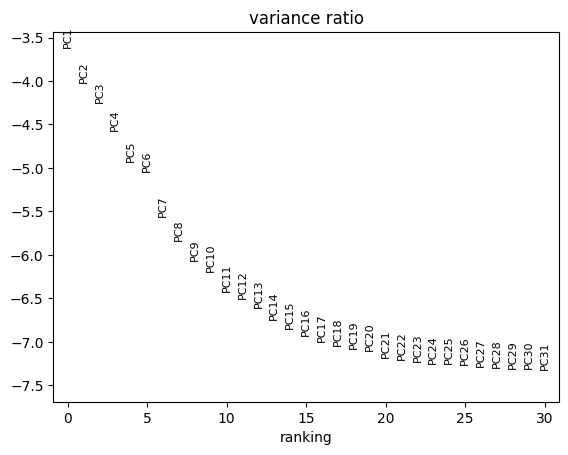

In [58]:
#print(adata_PA12.obsm["features"].shape)
print(adata_PA12.obsm["features"].columns[:20])  # look at first 20 column names
sc.pl.pca_variance_ratio(adata_PA12, log=True)


In [61]:
#debugging checks
# basic sizes / types
print("adata shape:", adata_PA12.shape)
print("n obs:", adata_PA12.n_obs)
print("adata.obs columns:", list(adata_PA12.obs.columns))

# clusters
print("\nfeatures_cluster present?", "features_cluster" in adata_PA12.obs)
print("leiden present?", "leiden" in adata_PA12.obs)
if "features_cluster" in adata_PA12.obs:
    print("features_cluster value counts:\n", adata_PA12.obs["features_cluster"].value_counts(dropna=False).head(10))
if "leiden" in adata_PA12.obs:
    print("leiden value counts:\n", adata_PA12.obs["leiden"].value_counts(dropna=False).head(10))

# features matrix
if "features" in adata_PA12.obsm:
    feats = adata_PA12.obsm["features"]
    print("\nfeatures shape:", getattr(feats, "shape", None))
    # if Pandas df
    try:
        print("features index matches adata.obs_names?:", all(feats.index == adata_PA12.obs_names))
    except Exception:
        print("features index check failed (not a DataFrame?)")

# spatial coordinates
sp = None
if "spatial" in adata_PA12.obsm:
    sp = adata_PA12.obsm["spatial"]
    print("\nspatial shape:", sp.shape)
    print("spatial min/max (x,y):", sp.min(axis=0), sp.max(axis=0))
else:
    # often spatial coords are under adata.obsm['spatial'] keyed by sample - try fallback
    print("\nadata.obsm keys:", list(adata_PA12.obsm.keys()))


adata shape: (4855, 18085)
n obs: 4855
adata.obs columns: ['in_tissue', 'array_row', 'array_col', 'leiden', 'features_cluster']

features_cluster present? True
leiden present? True
features_cluster value counts:
 features_cluster
0    96
1    95
2    95
3    95
4    95
5    91
6    90
7    90
8    89
9    89
Name: count, dtype: int64
leiden value counts:
 leiden
0    736
1    524
2    420
3    406
4    347
5    315
6    295
7    271
8    269
9    238
Name: count, dtype: int64

features shape: (4855, 30)
features index matches adata.obs_names?: True

spatial shape: (4855, 2)
spatial min/max (x,y): [0.8790841  0.53475256] [8.31809335 8.37443279]
